# Dependencies

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

# Reading in the data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls 

drive  sample_data


In [0]:
path = pathlib.Path('drive/My Drive/HuBlast')
path_images = path/'data'
path_masks = path/'masks'

In [0]:
path.ls()

[PosixPath('drive/My Drive/HuBlast/masks'),
 PosixPath('drive/My Drive/HuBlast/data')]

### Small sanity checks

In [0]:
get_image_files(path_images)[0:4]

[PosixPath('drive/My Drive/HuBlast/data/HuTcellBl_B15H1_5800x_0095.tif'),
 PosixPath('drive/My Drive/HuBlast/data/HuTcellBl_B15H1_5800x_0081.tif'),
 PosixPath('drive/My Drive/HuBlast/data/HuTcellBl_B15H1_5800x_0056.tif'),
 PosixPath('drive/My Drive/HuBlast/data/HuTcellBl_B15E1_5800x_0048.tif')]

In [0]:
get_image_files(path_masks)[0:4]

[PosixPath('drive/My Drive/HuBlast/masks/HuTcellBl_B15H1_5800x_0061.tif_segmentation.tifnomalized.tif'),
 PosixPath('drive/My Drive/HuBlast/masks/HuTcellBl_B15E1_5800x_0001.tif_segmentation.tifnomalized.tif'),
 PosixPath('drive/My Drive/HuBlast/masks/HuTcellBl_B15E1_5800x_0038.tif_segmentation.tifnomalized.tif'),
 PosixPath('drive/My Drive/HuBlast/masks/HuTcellBl_B15H1_5800x_0087.tif_segmentation.tifnomalized.tif')]

### Function for mapping X with Y

In [0]:
## Small function to get data correct with labelled data
get_y_fn = lambda x: path_masks/f'{x.stem}.tif_segmentation.tifnomalized.tif'

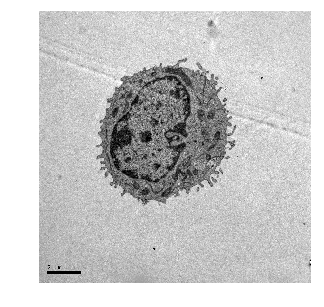

In [0]:
check1 = open_image(get_image_files(path_images)[3], )
check1.show(figsize=(5,5))

tensor([ 85, 170, 255])

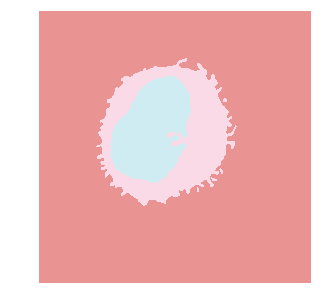

In [0]:
check2 = open_mask(get_y_fn(get_image_files(path_images)[3]))
check2.show(figsize=(5,5))
check2.data.unique()

### Creating the datablock

In [0]:
labels = array(['cell', 'void'])

In [0]:
## This piece of code FIXES the problem.
## MASK IMAGES CANNOT CONTAIN VALUES OF EITHER 0 or 255!
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom

In [0]:
src_size = np.array(check2.shape[1:])

In [0]:
size = src_size//4

In [0]:
## Creating the datablock (This makes life SO easy!)


src = (SegItemListCustom.from_folder(path_images)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=labels))

data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats)
       )

# Model and Accuracy Measures

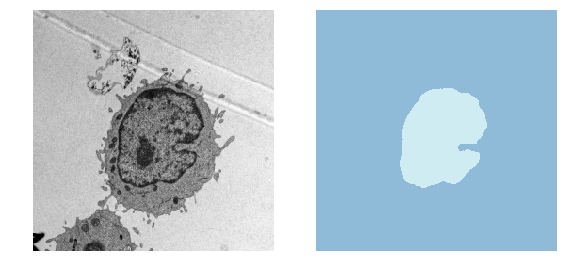

In [0]:
DataBunch.show_batch(data, 1)

In [0]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=1e-1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:06<00:00, 13508448.45it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


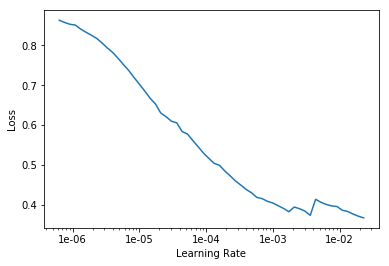

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.430014,0.391123,0.000000,00:17
1,0.310630,0.206974,0.056250,00:07
2,0.232056,0.119338,0.321762,00:07
3,0.181779,0.109114,0.452578,00:07
4,0.143865,0.075299,0.692380,00:07
5,0.116373,0.082293,0.655924,00:07
6,0.099076,0.099750,0.455283,00:07
7,0.085605,0.060859,0.745268,00:06
8,0.071734,0.058888,0.823385,00:07
9,0.063144,0.051513,0.823432,00:07


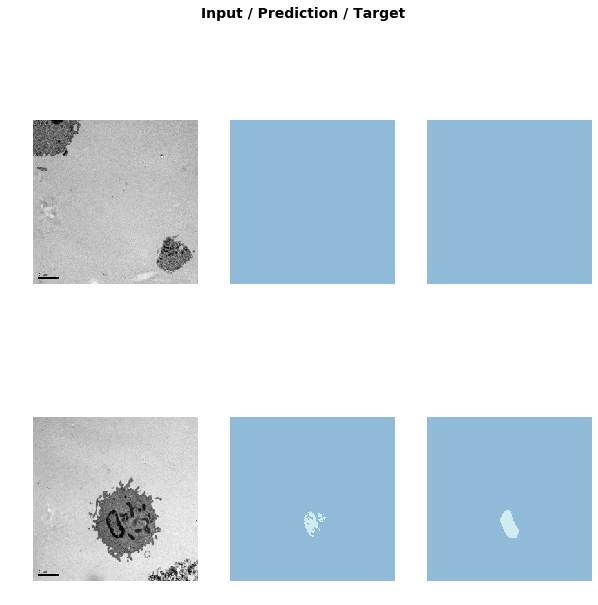

In [0]:
learn.show_results(rows=2, figsize=(10,10))

## Change the datasize and augmentations here to train our model on more

In [0]:
perspective_warp()

RandTransform(tfm=TfmCoord (perspective_warp), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)

In [0]:
tfms = [dihedral(), rotate(degrees=(-30,30), p=0.75), brightness(change=0.5)]
size = src_size // 2
## Creating the datablock (This makes life SO easy!)


src = (SegItemListCustom.from_folder(path_images)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=labels))

data = (src.transform(get_transforms(flip_vert=True, xtra_tfms=tfms), size=src_size//2, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats)
       )

## General steps to train model

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-4/400,1e-4/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.037427,0.050653,0.833956,00:07
1,0.035177,0.051573,0.833448,00:07
2,0.036795,0.055445,0.820798,00:07
3,0.036666,0.053853,0.823448,00:07
4,0.035278,0.054343,0.825657,00:07
5,0.034831,0.056772,0.823850,00:07
6,0.035520,0.051376,0.818688,00:07
7,0.036750,0.047005,0.836671,00:07
8,0.037108,0.048218,0.852439,00:07
9,0.036790,0.045472,0.853158,00:07


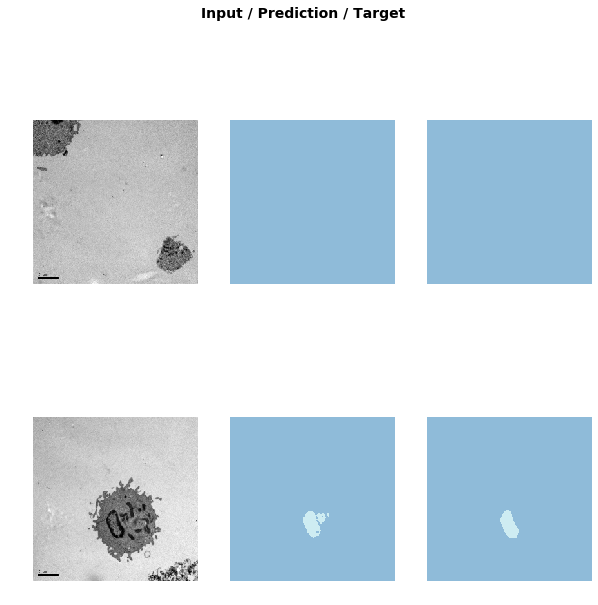

In [0]:
learn.show_results(rows=2, figsize=(10,10))

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


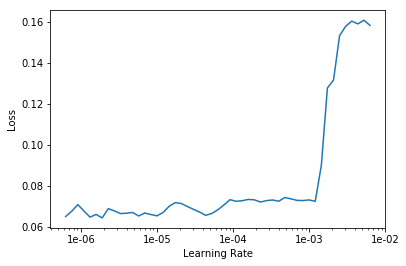

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-5, 1e-4, 1e-3)

In [0]:
learn.fit_one_cycle(8, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.062144,0.057758,0.754713,00:23
1,0.058197,0.063919,0.745097,00:21
2,0.053438,0.050877,0.766057,00:21
3,0.047324,0.054041,0.765734,00:21
4,0.043761,0.061036,0.776391,00:21
5,0.042500,0.071077,0.596096,00:21
6,0.044404,0.050241,0.808678,00:21
7,0.045052,0.060368,0.758707,00:21


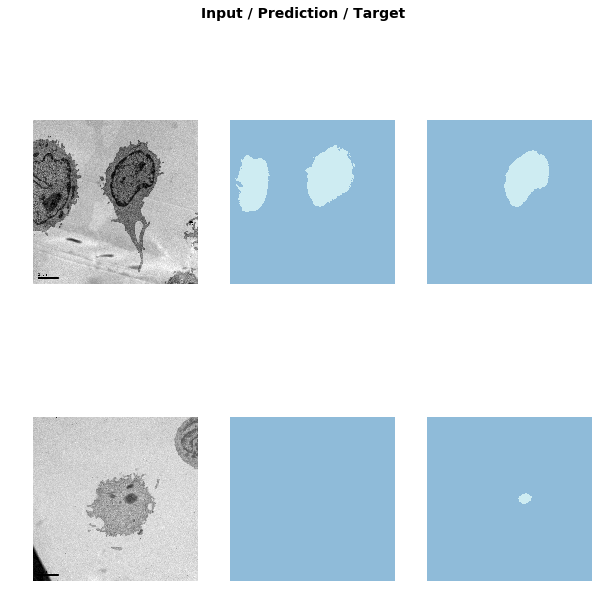

In [0]:
learn.show_results(rows=2, figsize=(10,10))

In [0]:
learn.save('Best_HuBlast')

In [0]:
learn.load('Best_HuBlast')

Learner(data=ImageDataBunch;

Train: LabelList (87 items)
x: SegItemListCustom
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegLabelListCustom
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: drive/My Drive/HuBlast/data;

Valid: LabelList (21 items)
x: SegItemListCustom
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegLabelListCustom
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: drive/My Drive/HuBlast/data;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      

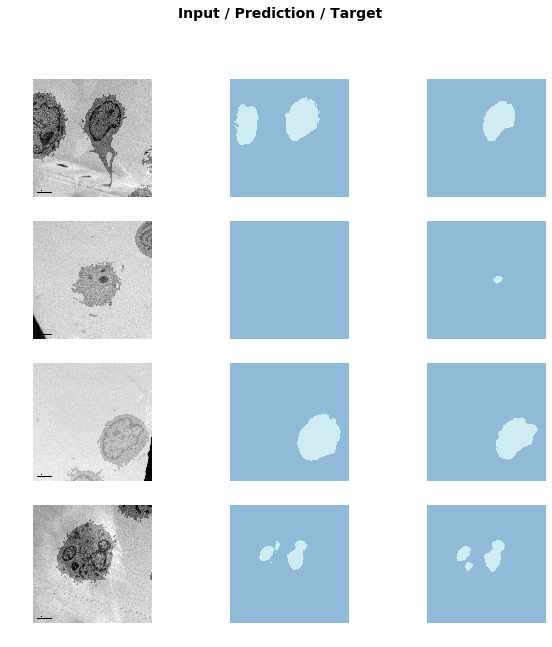

In [0]:
learn.show_results(rows=4, figsize=(10,10))

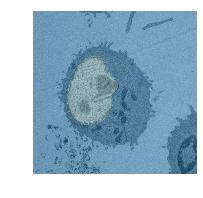

In [0]:
img = data.train_ds[8][0]
img.show(y=learn.predict(img)[0])

# Process all the images (Take into account z-stack) and then make it skeleton stuff